In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '15'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import partial

import models
from utility import lr_schlr
from canary_attack_bce import load_dataset, setup_model, evaluate_canary_attack, inject_canary
from canary_utility import local_training

In [2]:
rng_seed = None
dataset_key = "cifar100"
dataset_key_shadow = "cifar10"
batch_size_train = 256
batch_size_test = 64
# if pretrain model before canary injection (simulating FL)
pre_train = False

# attack
max_number_of_iters = 10000
#init_lr = .01
#setps_lrs = [1000, 2000]
#opt = tf.keras.optimizers.Adam(lr_schlr(init_lr, setps_lrs))
opt = tf.keras.optimizers.Adam()

model_id = 'resnet32'
canary_id = 'last_layer'
loss_function = models.sparse_classification_loss
max_number_of_iters = 2000
loss_threshold = 0.0005

# FedAVG
num_iter_fedAVG = 15
learning_rate_fedAVG = 0.001

name = '_'.join(map(str,[dataset_key, dataset_key_shadow, batch_size_train, loss_threshold, model_id, canary_id, loss_threshold, learning_rate_fedAVG]))
print(name)

cifar100_cifar10_256_0.0005_resnet32_last_layer_0.0005_0.001


# Load datasets

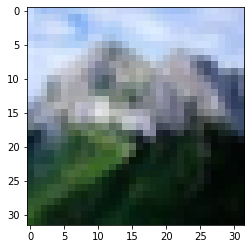

In [3]:
tf.random.set_seed(rng_seed)

validation, shadow, x_shape, class_num, (x_target, y_target) = load_dataset(
    dataset_key,
    dataset_key_shadow,
    batch_size_test,
    batch_size_train,
    data_aug_shadow=False
)
    
plt.imshow((x_target[0]+1)/2);

# Chosing canary location (i.e., $\xi$)

In [6]:
for i, l in enumerate(model.layers):
    print(i, l.name)

0 input_1
1 conv2d
2 layer_normalization
3 activation
4 conv2d_1
5 layer_normalization_1
6 activation_1
7 conv2d_2
8 layer_normalization_2
9 activation_2
10 tf.__operators__.add
11 conv2d_3
12 layer_normalization_3
13 activation_3
14 conv2d_4
15 layer_normalization_4
16 activation_4
17 tf.__operators__.add_1
18 conv2d_5
19 layer_normalization_5
20 activation_5
21 conv2d_6
22 layer_normalization_6
23 activation_6
24 tf.__operators__.add_2
25 conv2d_7
26 layer_normalization_7
27 activation_7
28 conv2d_8
29 layer_normalization_8
30 activation_8
31 tf.__operators__.add_3
32 conv2d_9
33 layer_normalization_9
34 activation_9
35 conv2d_10
36 layer_normalization_10
37 activation_10
38 tf.__operators__.add_4
39 conv2d_11
40 layer_normalization_11
41 activation_11
42 conv2d_12
43 layer_normalization_12
44 conv2d_13
45 activation_12
46 layer_normalization_13
47 tf.__operators__.add_5
48 conv2d_14
49 layer_normalization_14
50 activation_13
51 conv2d_15
52 layer_normalization_15
53 activation_14
54

In [7]:
models.canaries = {
    'resnet20':{
        'last_layer':(68, -2, 0)
    },
    'resnet32':{
        'last_layer':(110, -2, 0)
    }
    
}

model, layer_idx, g_canary_shift, kernel_idx, pre_canary_layer_trainable_variables = setup_model(model_id, canary_id, x_shape, class_num)

----> layer_normalization_65 (None, 8, 8, 64)
--------> (None, 8, 8)
input_2

conv2d_33
	 conv2d_33/kernel:0

layer_normalization_33
	 layer_normalization_33/gamma:0
	 layer_normalization_33/beta:0

activation_31

conv2d_34
	 conv2d_34/kernel:0

layer_normalization_34
	 layer_normalization_34/gamma:0
	 layer_normalization_34/beta:0

activation_32

conv2d_35
	 conv2d_35/kernel:0

layer_normalization_35
	 layer_normalization_35/gamma:0
	 layer_normalization_35/beta:0

activation_33

tf.__operators__.add_15

conv2d_36
	 conv2d_36/kernel:0

layer_normalization_36
	 layer_normalization_36/gamma:0
	 layer_normalization_36/beta:0

activation_34

conv2d_37
	 conv2d_37/kernel:0

layer_normalization_37
	 layer_normalization_37/gamma:0
	 layer_normalization_37/beta:0

activation_35

tf.__operators__.add_16

conv2d_38
	 conv2d_38/kernel:0

layer_normalization_38
	 layer_normalization_38/gamma:0
	 layer_normalization_38/beta:0

activation_36

conv2d_39
	 conv2d_39/kernel:0

layer_normalization_39
	

Loss Threshold reached!


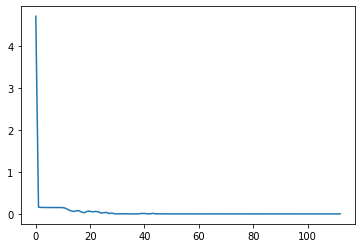

In [5]:
logs = inject_canary(
    max_number_of_iters,
    batch_size_train,
    model,
    x_target,
    shadow,
    pre_canary_layer_trainable_variables,
    opt,
    loss_threshold=loss_threshold
)

plt.plot(logs[0]);

In [6]:
test_canary_fn = partial(
    evaluate_canary_attack,
    target=x_target,
    dataset_validation=validation,
    variables=pre_canary_layer_trainable_variables,
    loss_function=loss_function,
    g_canary_shift=g_canary_shift,
    kernel_idx=kernel_idx
)

out, failed = test_canary_fn(model)
out

Max number of iterations evaluation reached!


{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}

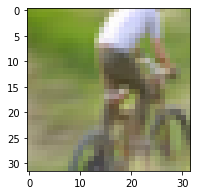

In [7]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow((x_target[0]+1)/2);

for x in failed[:5]:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.imshow((x[0]+1)/2)

In [8]:
canary_scores_FedAVG = local_training(
    model,
    validation,
    num_iter_fedAVG,
    learning_rate_fedAVG,
    loss_function,
    test_canary_fn
)

Max number of iterations evaluation reached!
 FedAVG round: 1
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 2
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 3
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 4
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 5
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 6
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 7
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 8
	{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}
Max number of iterations evaluation reached!
 FedAVG round: 9
	{'accuracy': 1.0, 'recall

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot([x['accuracy'] for x in canary_scores_FedAVG])
ax.set(ylim=(.5,1))
ax.grid();

In [18]:
import myPickle
myPickle.dump?

Signature: myPickle.dump(filename, data, **kargs)
Docstring: <no docstring>
File:      ~/LIBS/myPickle.py
Type:      function
